# STEP 1: Analyze Real Cities (500×500m)
## Extract Urban Metrics & Building Footprint Library

**Goal**: Analyze three 500×500m urban areas to extract:
- Space syntax metrics (nodes, edges, districts, landmarks)
- Building footprint library (individual building shapes)
- Building parcels (land use boundaries)
- Building geometry distributions

**Cities**:
1. Hanoi, Vietnam (21.0230°N, 105.8560°E) - Dense, organic layout
2. Brussels, Belgium (50.8477°N, 4.3572°E) - European historic core
3. Marrakech, Morocco (31.623811°N, -7.988662°W) - Compact medina

**Outputs**:
- GeoJSON files (nodes, edges, buildings, parcels, districts)
- JSON metrics file (urban_metrics.json)
- Building footprint library (building_footprint_library.json)
- Visualizations (PNG + SVG)
- Metrics summary table (CSV)

## 1. Setup & Configuration

In [5]:
# Imports
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, box
from shapely.ops import unary_union
from shapely.affinity import translate
import json
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Configure OSMnx
ox.settings.use_cache = True
ox.settings.log_console = False

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [6]:
# Configuration
CITIES = {
    'london': {
        'name': 'London, UK',
        'coords': (51.5108708294874, -0.1301202729436442),
        'color': '#E74C3C'
    },
    'berlin': {
        'name': 'Berlin, Germany',
        'coords': (52.52832783083204, 13.40299924970717),
        'color': '#3498DB'
    },
    'belgrade': {
        'name': 'Belgrade, Serbia',
        'coords': (44.81648489551224, 20.462214816208164),
        'color': '#2ECC71'
    },
    'torino': {
        'name': 'Torino, Italy',
        'coords': (45.06940684010285, 7.682084193995683),
        'color': '#F39C12'
    }
}

# Analysis parameters (adapted for 500×500m)
RADIUS = 250  # meters
REACH_RADII = [200, 300]
LOCAL_LANDMARK_RADIUS = 300
MIN_PARCEL_AREA = 500  # m²
MAX_PARCEL_AREA = 10000  # m²
FOOTPRINTS_PER_CITY = 35  # Target library size
LANDMARK_THRESHOLD = 0.4  # Hard threshold for landmark identification (no max limit)

# Output paths
OUTPUT_DIR = Path('outputs')
GEOJSON_DIR = OUTPUT_DIR / 'geojson'
VIZ_PNG_DIR = OUTPUT_DIR / 'visualizations' / 'png'
VIZ_SVG_DIR = OUTPUT_DIR / 'visualizations' / 'svg'
METRICS_DIR = OUTPUT_DIR / 'metrics'

for d in [GEOJSON_DIR, VIZ_PNG_DIR, VIZ_SVG_DIR, METRICS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("✓ Configuration complete")
print(f"  Analyzing {len(CITIES)} cities")
print(f"  Coverage radius: {RADIUS}m (~{RADIUS*2}×{RADIUS*2}m)")
print(f"  Output: {OUTPUT_DIR.absolute()}")

✓ Configuration complete
  Analyzing 4 cities
  Coverage radius: 250m (~500×500m)
  Output: c:\Users\shrua\OneDrive\Desktop\comp_city\inv_city\outputs


## 2. Data Acquisition

In [3]:
# Download data for all cities
city_data = {}

for city_key, city_info in CITIES.items():
    print(f"\n{'='*60}")
    print(f"Downloading: {city_info['name']}")
    print(f"{'='*60}")
    
    lat, lon = city_info['coords']
    
    try:
        # 1. Street network - GET ALL ROADS (all hierarchy levels)
        print(f"  → Street network (all types)...")
        G = ox.graph_from_point((lat, lon), dist=RADIUS, network_type='all', simplify=True)
        G_proj = ox.project_graph(G)
        
        # 2. Buildings
        print(f"  → Buildings...")
        buildings = ox.features_from_point((lat, lon), dist=RADIUS, tags={'building': True})
        buildings_proj = buildings.to_crs(ox.graph_to_gdfs(G_proj, nodes=False).crs)
        buildings_proj = buildings_proj[buildings_proj.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
        
        # Convert MultiPolygons to Polygons
        def get_polygon(geom):
            if geom.geom_type == 'Polygon':
                return geom
            elif geom.geom_type == 'MultiPolygon':
                return max(geom.geoms, key=lambda p: p.area)
            return geom
        
        buildings_proj['geometry'] = buildings_proj.geometry.apply(get_polygon)
        buildings_proj = buildings_proj[buildings_proj.geometry.type == 'Polygon'].copy()
        
        # 3. Building Parcels - TRY MULTIPLE LAYERS for complete coverage
        print(f"  → Building parcels (multiple layers)...")
        parcels_list = []
        
        # Try landuse tags
        try:
            parcels_landuse = ox.features_from_point((lat, lon), dist=RADIUS, tags={'landuse': True})
            parcels_list.append(parcels_landuse)
            print(f"    ✓ Found {len(parcels_landuse)} landuse parcels")
        except:
            pass
        
        # Try boundary tags (administrative boundaries, property boundaries)
        try:
            parcels_boundary = ox.features_from_point((lat, lon), dist=RADIUS, tags={'boundary': 'administrative'})
            parcels_list.append(parcels_boundary)
            print(f"    ✓ Found {len(parcels_boundary)} boundary parcels")
        except:
            pass
        
        # Combine all parcel sources
        if parcels_list:
            parcels = pd.concat(parcels_list, ignore_index=True)
            parcels = gpd.GeoDataFrame(parcels, geometry='geometry')
            parcels_proj = parcels.to_crs(ox.graph_to_gdfs(G_proj, nodes=False).crs)
            parcels_proj = parcels_proj[parcels_proj.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
            parcels_proj['geometry'] = parcels_proj.geometry.apply(get_polygon)
            parcels_proj = parcels_proj[parcels_proj.geometry.type == 'Polygon'].copy()
            # Remove duplicates
            parcels_proj = parcels_proj.drop_duplicates(subset=['geometry'])
            print(f"    ✓ Total {len(parcels_proj)} parcels (combined)")
        else:
            print(f"    ⚠ No parcels found")
            parcels_proj = gpd.GeoDataFrame(columns=['geometry'], crs=ox.graph_to_gdfs(G_proj, nodes=False).crs)
        
        # Store data
        city_data[city_key] = {
            'name': city_info['name'],
            'color': city_info['color'],
            'coords': (lat, lon),
            'graph': G_proj,
            'buildings': buildings_proj,
            'parcels': parcels_proj,
            'crs': ox.graph_to_gdfs(G_proj, nodes=False).crs
        }
        
        print(f"  ✓ Downloaded:")
        print(f"    - {G_proj.number_of_nodes()} nodes")
        print(f"    - {G_proj.number_of_edges()} edges")
        print(f"    - {len(buildings_proj)} buildings")
        print(f"    - {len(parcels_proj)} parcels")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print(f"✓ Data acquisition complete for {len(city_data)} cities")
print(f"{'='*60}")


Downloading: London, UK
  → Street network (all types)...
  → Buildings...
  → Building parcels (multiple layers)...
    ✓ Found 30 landuse parcels
    ✓ Found 3 boundary parcels
    ✓ Total 32 parcels (combined)
  ✓ Downloaded:
    - 525 nodes
    - 1431 edges
    - 507 buildings
    - 32 parcels

Downloading: Berlin, Germany
  → Street network (all types)...
  → Buildings...
  → Building parcels (multiple layers)...
    ✓ Found 29 landuse parcels
    ✓ Found 4 boundary parcels
    ✓ Total 33 parcels (combined)
  ✓ Downloaded:
    - 403 nodes
    - 1105 edges
    - 433 buildings
    - 33 parcels

Downloading: Belgrade, Serbia
  → Street network (all types)...
  → Buildings...
  → Building parcels (multiple layers)...
    ✓ Found 2 landuse parcels
    ✓ Found 1 boundary parcels
    ✓ Total 3 parcels (combined)
  ✓ Downloaded:
    - 286 nodes
    - 802 edges
    - 356 buildings
    - 3 parcels

Downloading: Torino, Italy
  → Street network (all types)...
  → Buildings...
  → Building p

## 2.5 NEW: Base Map Visualization
Display the full urban context before analysis


Creating base maps...


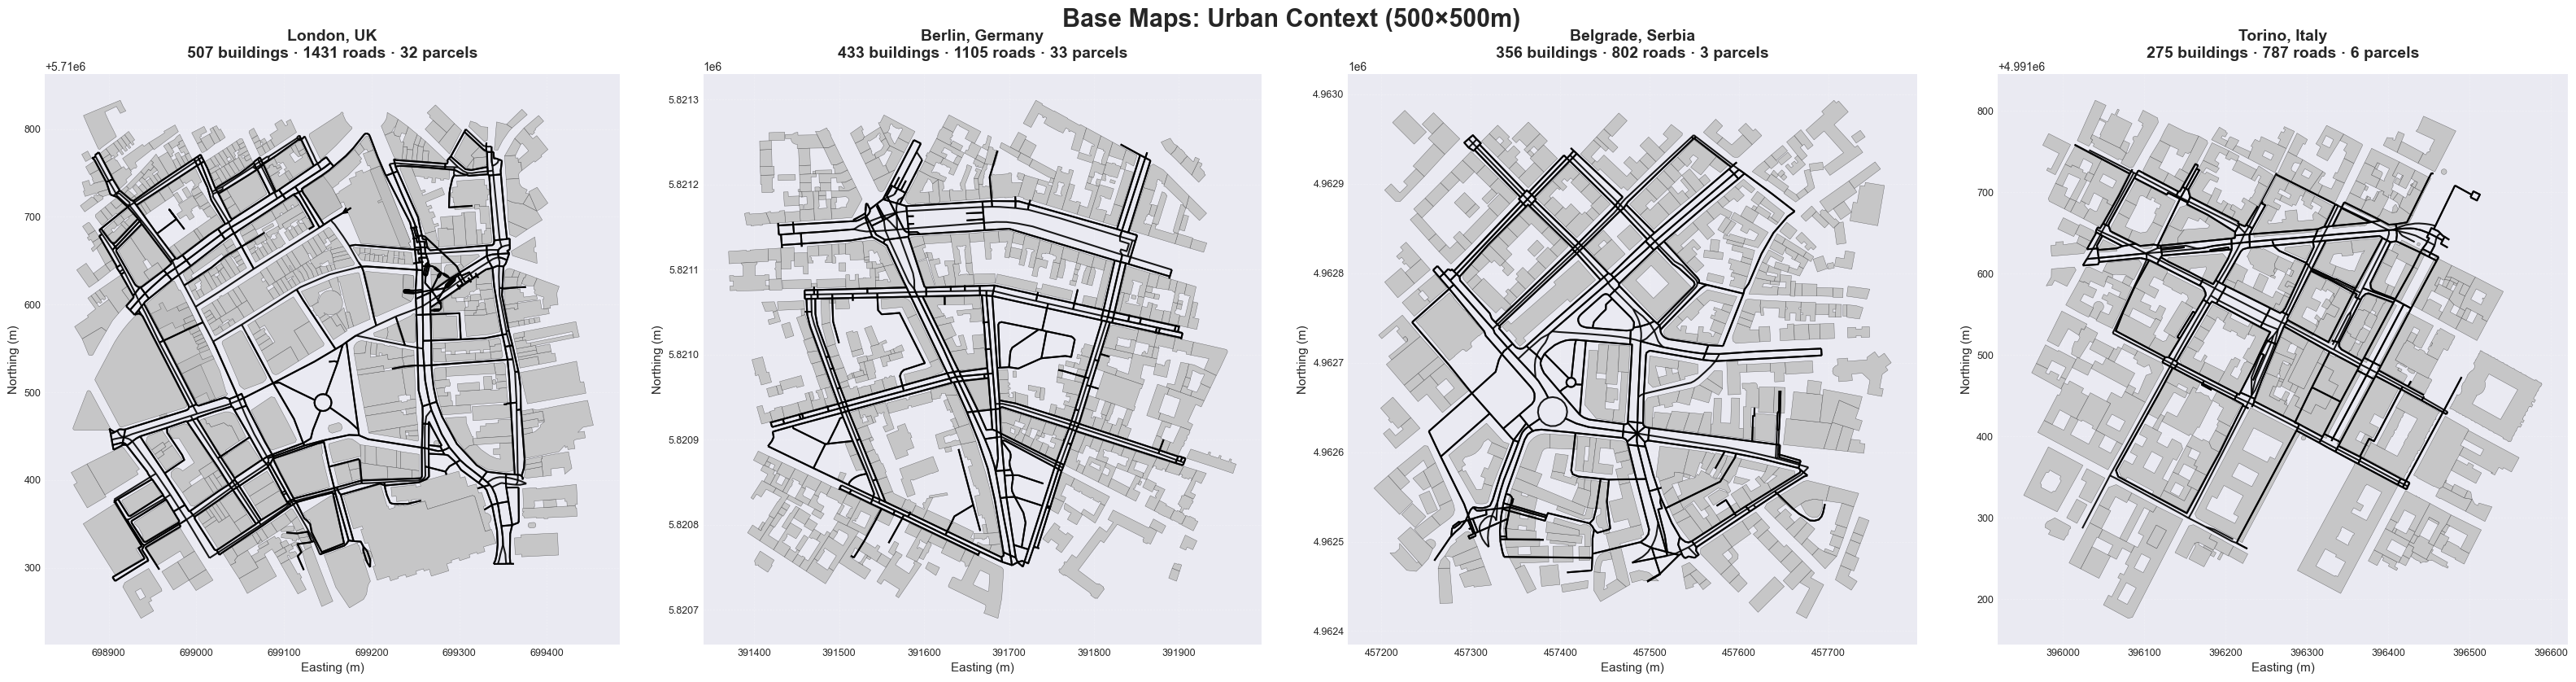

✓ Saved: 00_base_maps.png + 00_base_maps.svg
  (Buildings in gray, roads in black, parcels in light green)


In [8]:
# Base maps showing roads + buildings + parcels
print("\n" + "="*60)
print("Creating base maps...")
print("="*60)

fig, axes = plt.subplots(1, 4, figsize=(32, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    _, edges = ox.graph_to_gdfs(city_data[city_key]['graph'])
    buildings = city_data[city_key]['buildings']
    parcels = city_data[city_key]['parcels']
    
    # Plot parcels in light green (if available)
    #if len(parcels) > 0:
      #  parcels.plot(ax=ax, color='#E8F5E9', edgecolor='#66BB6A', linewidth=0.5, alpha=0.3)
    
    # Plot buildings in gray
    buildings.plot(ax=ax, color='#BDBDBD', edgecolor='#424242', linewidth=0.3, alpha=0.8)
    
    # Plot roads in black
    edges.plot(ax=ax, color='#000000', linewidth=1.5, alpha=0.9)
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"{len(buildings)} buildings · {len(edges)} roads · {len(parcels)} parcels",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.suptitle('Base Maps: Urban Context (500×500m)', fontsize=22, fontweight='bold', y=1.0)
plt.tight_layout()

# Save both formats
plt.savefig(VIZ_PNG_DIR / '00_base_maps.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '00_base_maps.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 00_base_maps.png + 00_base_maps.svg")
print("  (Buildings in gray, roads in black, parcels in light green)")

## 3. Node Analysis (Centrality Metrics)

In [9]:
def compute_node_metrics(G):
    """Compute centrality metrics for nodes"""
    print("  Computing node centrality...")
    
    G_undir = G.to_undirected()
    
    # Betweenness centrality
    print("    - Betweenness (distance)...")
    bc_dist = nx.betweenness_centrality(G_undir, weight='length', normalized=True)
    bc_info = nx.betweenness_centrality(G_undir, weight=None, normalized=True)
    
    # Closeness centrality
    print("    - Closeness...")
    closeness = nx.closeness_centrality(G_undir, distance='length')
    
    # Reach centrality
    print("    - Reach (200m, 300m)...")
    reach_200 = {}
    reach_300 = {}
    for node in G_undir.nodes():
        reach_200[node] = len(nx.single_source_dijkstra_path_length(G_undir, node, cutoff=200, weight='length'))
        reach_300[node] = len(nx.single_source_dijkstra_path_length(G_undir, node, cutoff=300, weight='length'))
    
    degree = dict(G_undir.degree())
    
    nodes, _ = ox.graph_to_gdfs(G)
    nodes['bc_distance'] = nodes.index.map(bc_dist)
    nodes['bc_information'] = nodes.index.map(bc_info)
    nodes['closeness'] = nodes.index.map(closeness)
    nodes['reach_200m'] = nodes.index.map(reach_200)
    nodes['reach_300m'] = nodes.index.map(reach_300)
    nodes['degree'] = nodes.index.map(degree)
    
    print("  ✓ Node metrics computed")
    return nodes

for city_key in city_data.keys():
    print(f"\n{city_data[city_key]['name']}:")
    city_data[city_key]['nodes'] = compute_node_metrics(city_data[city_key]['graph'])
    city_data[city_key]['nodes'].to_file(GEOJSON_DIR / f"{city_key}_nodes.geojson", driver='GeoJSON')
    print(f"  ✓ Saved to {city_key}_nodes.geojson")


London, UK:
  Computing node centrality...
    - Betweenness (distance)...
    - Closeness...
    - Reach (200m, 300m)...
  ✓ Node metrics computed
  ✓ Saved to london_nodes.geojson

Berlin, Germany:
  Computing node centrality...
    - Betweenness (distance)...
    - Closeness...
    - Reach (200m, 300m)...
  ✓ Node metrics computed
  ✓ Saved to berlin_nodes.geojson

Belgrade, Serbia:
  Computing node centrality...
    - Betweenness (distance)...
    - Closeness...
    - Reach (200m, 300m)...
  ✓ Node metrics computed
  ✓ Saved to belgrade_nodes.geojson

Torino, Italy:
  Computing node centrality...
    - Betweenness (distance)...
    - Closeness...
    - Reach (200m, 300m)...
  ✓ Node metrics computed
  ✓ Saved to torino_nodes.geojson



1/6: Creating Node Centrality visualizations...


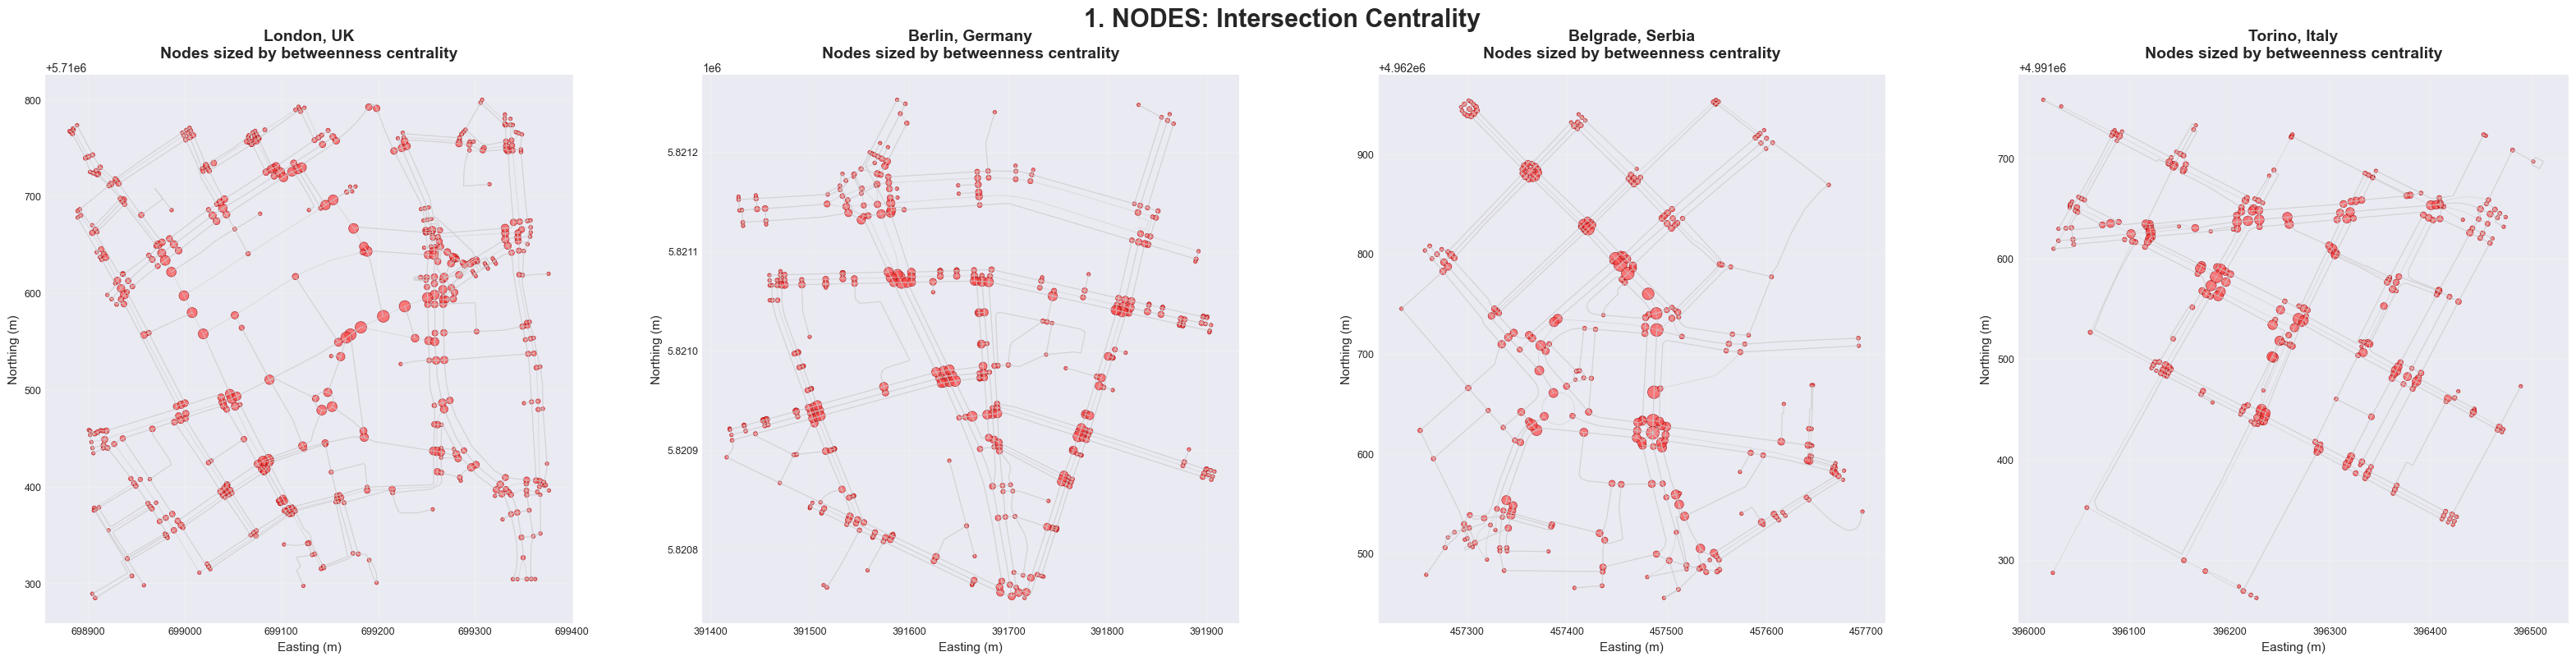

✓ Saved: 01_nodes_centrality (PNG + SVG)


In [15]:
# 1. NODES - Centrality-based visualization
print("\n" + "="*60)
print("1/6: Creating Node Centrality visualizations...")
print("="*60)

fig, axes = plt.subplots(1, 4, figsize=(32, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    nodes_gdf = city_data[city_key]['nodes']
    edges_gdf = city_data[city_key]['edges']
    
    # Plot edges first (background)
    edges_gdf.plot(ax=ax, color='#CCCCCC', linewidth=0.8, alpha=0.5)
    
    # Plot nodes with size based on betweenness centrality
    node_sizes = (nodes_gdf['bc_distance'] * 500) + 10  # Scale for visibility
    nodes_gdf.plot(
        ax=ax,
        markersize=node_sizes,
        color='#FF4444',
        alpha=0.7,
        edgecolor='darkred',
        linewidth=0.5
    )
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"Nodes sized by betweenness centrality",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('1. NODES: Intersection Centrality', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '01_nodes_centrality.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '01_nodes_centrality.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 01_nodes_centrality (PNG + SVG)")

## 4. Edge Analysis

In [13]:
def compute_edge_metrics(G):
    """Compute edge metrics"""
    print("  Computing edge metrics...")
    
    G_undir = G.to_undirected()
    
    print("    - Edge betweenness...")
    edge_bc = nx.edge_betweenness_centrality(G_undir, weight='length', normalized=True)
    
    # Dual graph for angular analysis
    print("    - Angular betweenness...")
    dual_G = nx.Graph()
    edge_to_node = {}
    for i, (u, v, k) in enumerate(G_undir.edges(keys=True)):
        edge_to_node[(u, v, k)] = i
        dual_G.add_node(i, primal_edge=(u, v, k))
    
    for node in G_undir.nodes():
        incident_edges = list(G_undir.edges(node, keys=True))
        for i in range(len(incident_edges)):
            for j in range(i+1, len(incident_edges)):
                e1, e2 = incident_edges[i], incident_edges[j]
                e1_norm = tuple(sorted([e1[0], e1[1]])) + (e1[2],)
                e2_norm = tuple(sorted([e2[0], e2[1]])) + (e2[2],)
                if e1_norm in edge_to_node and e2_norm in edge_to_node:
                    dual_G.add_edge(edge_to_node[e1_norm], edge_to_node[e2_norm])
    
    dual_bc = nx.betweenness_centrality(dual_G, weight=None, normalized=True) if dual_G.number_of_edges() > 0 else {}
    angular_bc = {}
    for dual_node, bc_val in dual_bc.items():
        primal_edge = dual_G.nodes[dual_node].get('primal_edge')
        if primal_edge:
            angular_bc[primal_edge] = bc_val
    
    _, edges = ox.graph_to_gdfs(G)
    edges['edge_bc'] = edges.index.map(lambda x: edge_bc.get((x[0], x[1]), 0))
    edges['angular_bc'] = edges.index.map(lambda x: angular_bc.get(x, 0))
    
    print("  ✓ Edge metrics computed")
    return edges

for city_key in city_data.keys():
    print(f"\n{city_data[city_key]['name']}:")
    city_data[city_key]['edges'] = compute_edge_metrics(city_data[city_key]['graph'])
    city_data[city_key]['edges'].to_file(GEOJSON_DIR / f"{city_key}_edges.geojson", driver='GeoJSON')
    print(f"  ✓ Saved to {city_key}_edges.geojson")


London, UK:
  Computing edge metrics...
    - Edge betweenness...
    - Angular betweenness...
  ✓ Edge metrics computed
  ✓ Saved to london_edges.geojson

Berlin, Germany:
  Computing edge metrics...
    - Edge betweenness...
    - Angular betweenness...
  ✓ Edge metrics computed
  ✓ Saved to berlin_edges.geojson

Belgrade, Serbia:
  Computing edge metrics...
    - Edge betweenness...
    - Angular betweenness...
  ✓ Edge metrics computed
  ✓ Saved to belgrade_edges.geojson

Torino, Italy:
  Computing edge metrics...
    - Edge betweenness...
    - Angular betweenness...
  ✓ Edge metrics computed
  ✓ Saved to torino_edges.geojson



4/6: Creating Path (edge betweenness) visualizations...


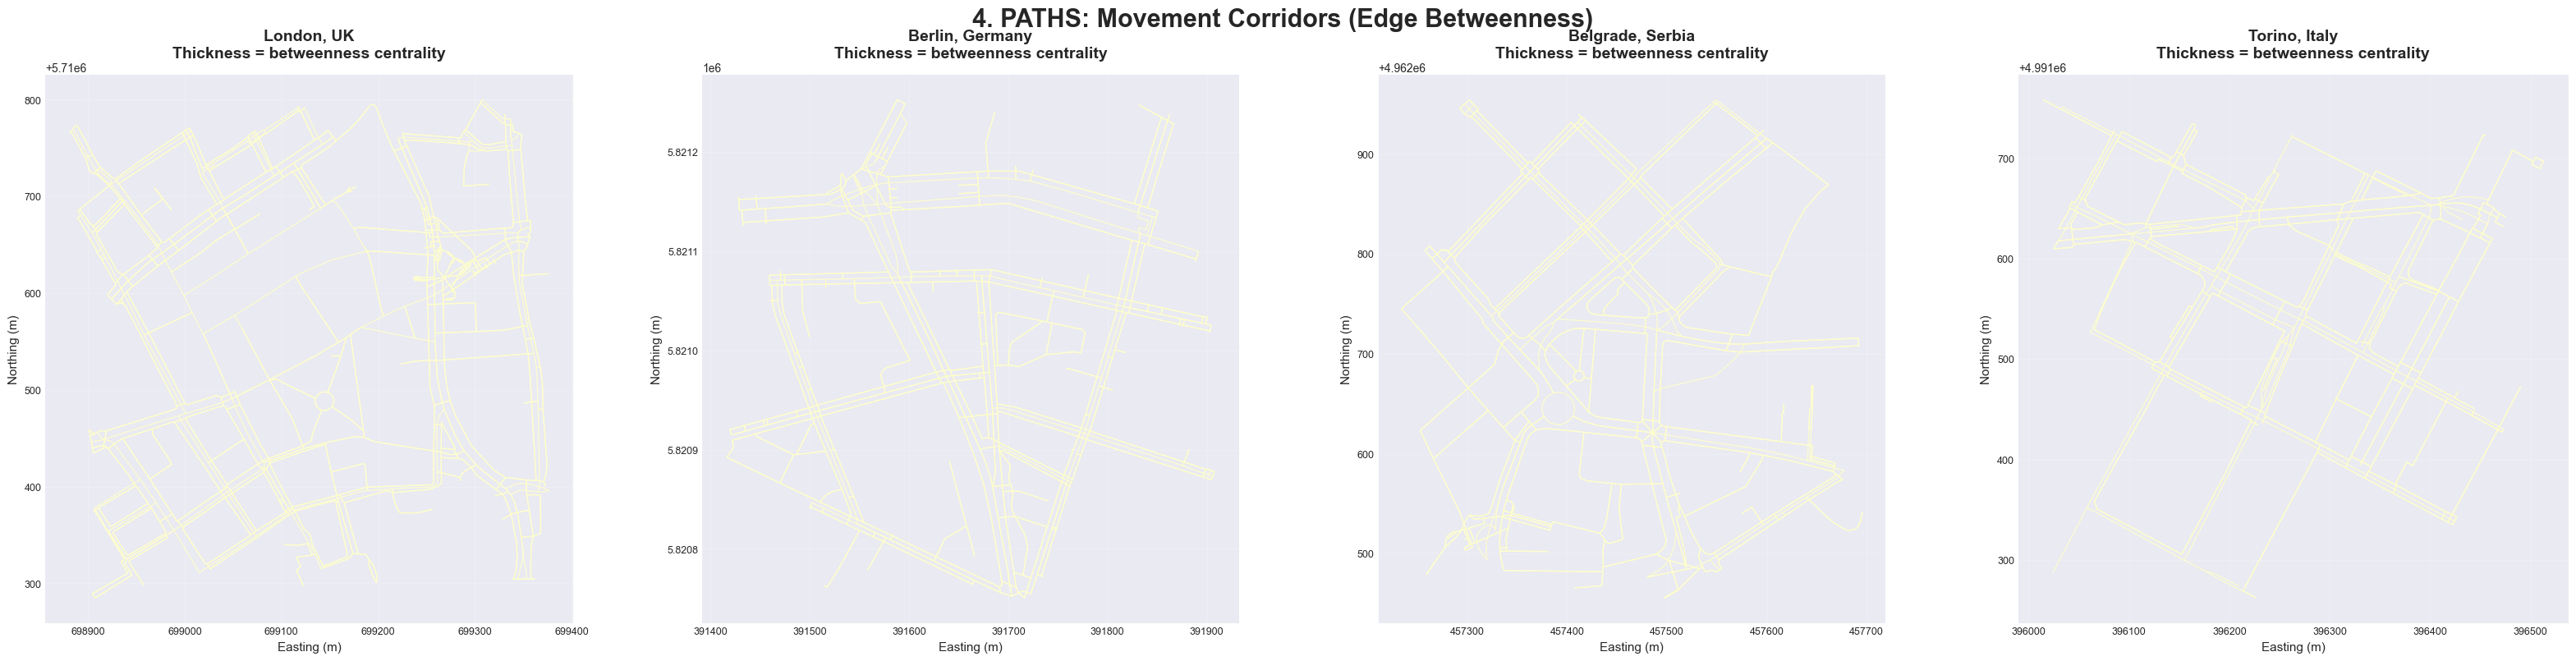

✓ Saved: 04_paths_betweenness (PNG + SVG)


In [16]:
# 4. PATHS - Edge betweenness (movement corridors)
print("\n" + "="*60)
print("4/6: Creating Path (edge betweenness) visualizations...")
print("="*60)

fig, axes = plt.subplots(1, 4, figsize=(32, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    edges_gdf = city_data[city_key]['edges']
    
    # Plot edges with width based on betweenness
    max_bc = edges_gdf['edge_bc'].max()
    if max_bc > 0:
        linewidths = (edges_gdf['edge_bc'] / max_bc) * 5 + 0.5
    else:
        linewidths = 1.0
    
    edges_gdf.plot(
        ax=ax,
        column='edge_bc',
        cmap='YlOrRd',
        linewidth=linewidths,
        alpha=0.8,
        legend=False
    )
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"Thickness = betweenness centrality",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('4. PATHS: Movement Corridors (Edge Betweenness)', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '04_paths_betweenness.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '04_paths_betweenness.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 04_paths_betweenness (PNG + SVG)")


5/6: Creating Edge (connectivity) visualizations...


IndexError: index 3 is out of bounds for axis 0 with size 3

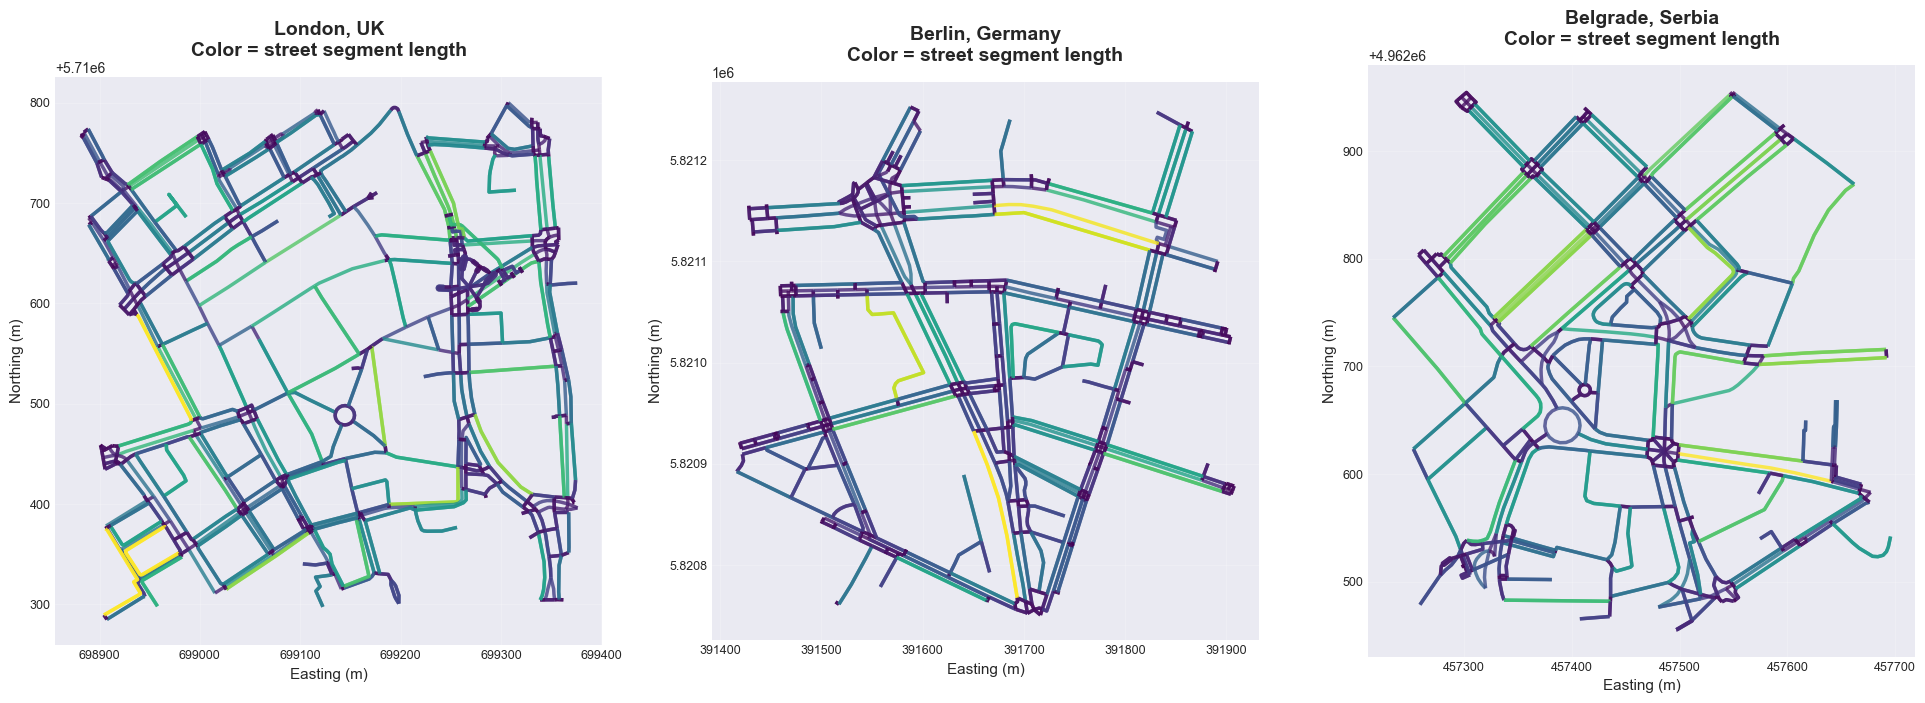

In [17]:
# 5. EDGES - Street connectivity by length
print("\n" + "="*60)
print("5/6: Creating Edge (connectivity) visualizations...")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    edges_gdf = city_data[city_key]['edges']
    
    # Plot with edge length (connectivity structure)
    edges_gdf.plot(
        ax=ax,
        column='length',
        cmap='viridis',
        linewidth=2.5,
        alpha=0.8,
        legend=False
    )
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"Color = street segment length",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('5. EDGES: Street Network Connectivity', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '05_edges_connectivity.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '05_edges_connectivity.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 05_edges_connectivity (PNG + SVG)")

## 5. Parcel Analysis
Process building parcels (landuse boundaries)

In [18]:
# Process parcels and compute metrics
for city_key in city_data.keys():
    print(f"\n{city_data[city_key]['name']}:")
    parcels = city_data[city_key]['parcels']
    
    if len(parcels) > 0:
        print("  Processing parcels...")
        parcels['area'] = parcels.geometry.area
        parcels['perimeter'] = parcels.geometry.length
        parcels['compactness'] = (4 * np.pi * parcels['area']) / (parcels['perimeter'] ** 2)
        
        # Filter by size
        parcels_filtered = parcels[
            (parcels['area'] >= MIN_PARCEL_AREA) & 
            (parcels['area'] <= MAX_PARCEL_AREA)
        ].copy()
        
        # Compute aspect ratio
        aspect_ratios = []
        for geom in parcels_filtered.geometry:
            try:
                mbr = geom.minimum_rotated_rectangle
                coords = list(mbr.exterior.coords)
                side1 = Point(coords[0]).distance(Point(coords[1]))
                side2 = Point(coords[1]).distance(Point(coords[2]))
                aspect = max(side1, side2) / min(side1, side2) if min(side1, side2) > 0 else 1.0
                aspect_ratios.append(aspect)
            except:
                aspect_ratios.append(1.0)
        
        parcels_filtered['aspect_ratio'] = aspect_ratios
        parcels_filtered['parcel_id'] = [f"parcel_{i:03d}" for i in range(len(parcels_filtered))]
        
        city_data[city_key]['parcels_processed'] = parcels_filtered
        
        # Save
        parcels_filtered.to_file(GEOJSON_DIR / f"{city_key}_parcels.geojson", driver='GeoJSON')
        print(f"  ✓ Processed {len(parcels_filtered)} parcels (filtered from {len(parcels)})")
        print(f"  ✓ Saved to {city_key}_parcels.geojson")
    else:
        print("  ⚠ No parcels available")
        city_data[city_key]['parcels_processed'] = gpd.GeoDataFrame()


London, UK:
  Processing parcels...
  ✓ Processed 14 parcels (filtered from 32)
  ✓ Saved to london_parcels.geojson

Berlin, Germany:
  Processing parcels...
  ✓ Processed 11 parcels (filtered from 33)
  ✓ Saved to berlin_parcels.geojson

Belgrade, Serbia:
  Processing parcels...
  ✓ Processed 1 parcels (filtered from 3)
  ✓ Saved to belgrade_parcels.geojson

Torino, Italy:
  Processing parcels...
  ✓ Processed 3 parcels (filtered from 6)
  ✓ Saved to torino_parcels.geojson



3/6: Creating Parcel visualizations...


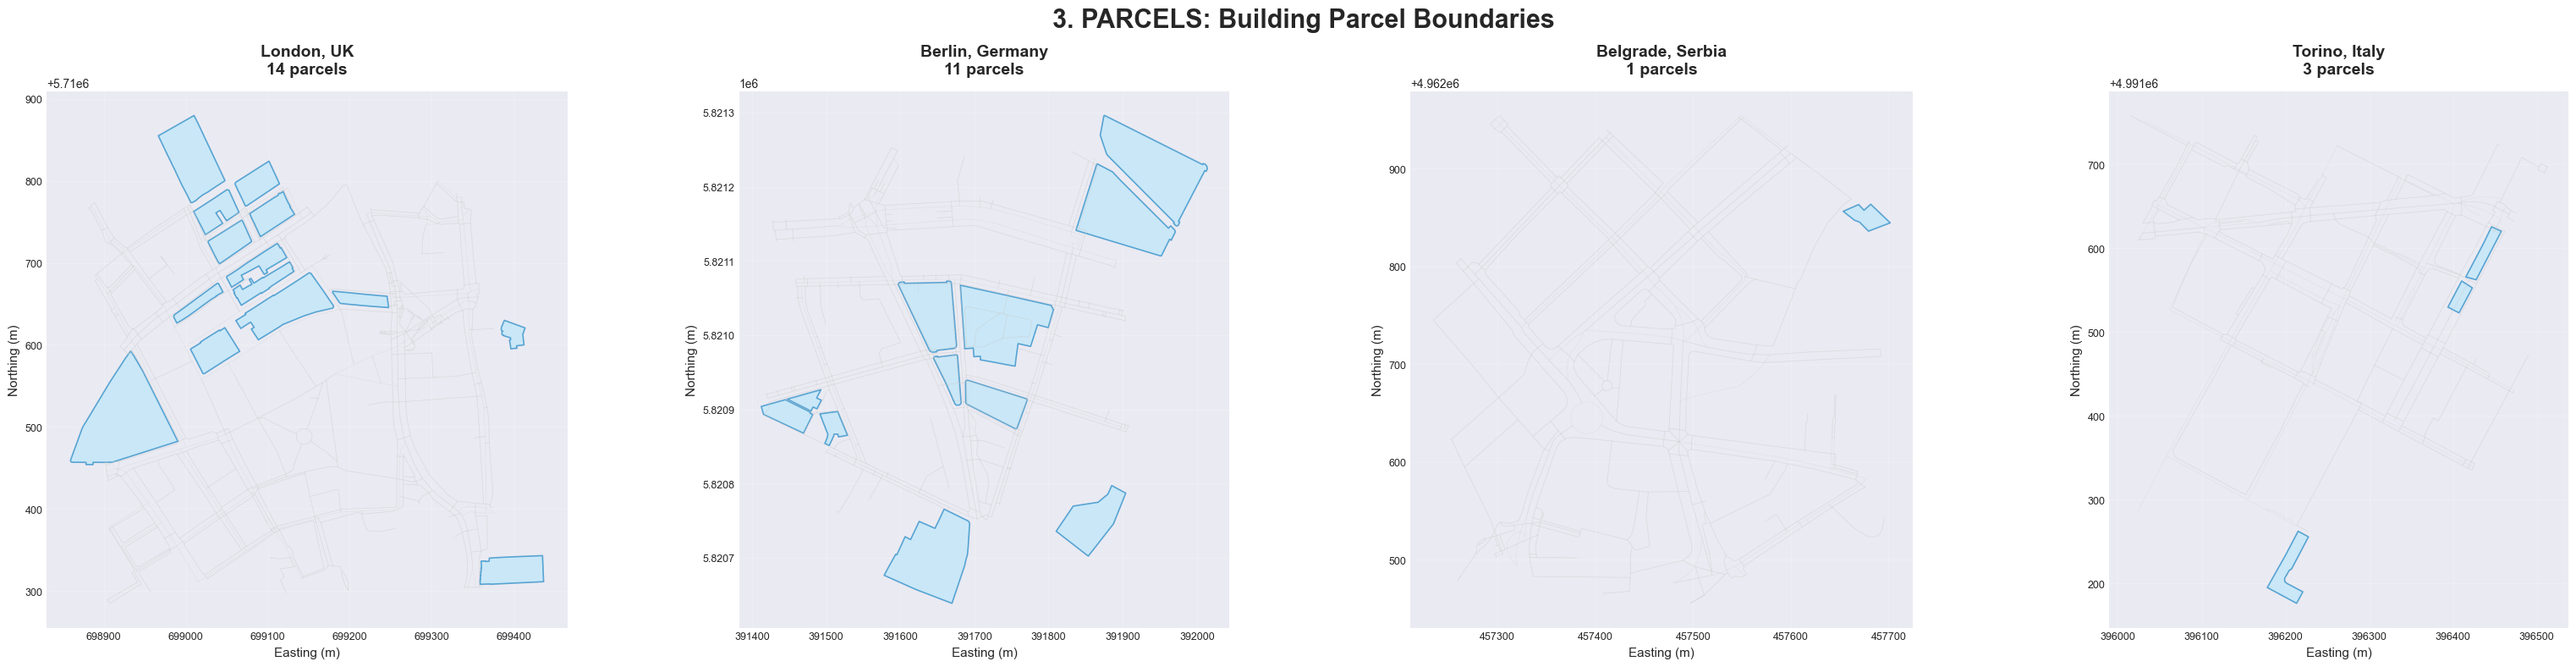

✓ Saved: 03_parcels (PNG + SVG)


In [19]:
# 3. PARCELS - Building parcel visualization
print("\n" + "="*60)
print("3/6: Creating Parcel visualizations...")
print("="*60)

fig, axes = plt.subplots(1, 4, figsize=(32, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    parcels = city_data[city_key]['parcels_processed']
    edges_gdf = city_data[city_key]['edges']
    
    # Plot edges (background)
    edges_gdf.plot(ax=ax, color='#CCCCCC', linewidth=0.5, alpha=0.3)
    
    if len(parcels) > 0:
        # Plot parcels in uniform color (no district coloring)
        parcels.plot(
            ax=ax,
            color='#B3E5FC',
            edgecolor='#0277BD',
            linewidth=1.2,
            alpha=0.6
        )
        
        parcel_info = f"{len(parcels)} parcels"
    else:
        parcel_info = "No parcels"
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"{parcel_info}",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('3. PARCELS: Building Parcel Boundaries', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '03_parcels.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '03_parcels.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 03_parcels (PNG + SVG)")

## 6. District Analysis

In [20]:
# NetworkX has built-in Louvain community detection (since v2.5+)
# No external packages needed
print("✓ Using NetworkX built-in Louvain community detection")

✓ Using NetworkX built-in Louvain community detection


In [21]:
def detect_districts(G, method='distance'):
    """Detect districts using community detection"""
    print(f"    - {method}...")
    try:
        G_undir = G.to_undirected()
        G_simple = nx.Graph()
        for u, v, data in G_undir.edges(data=True):
            if not G_simple.has_edge(u, v):
                G_simple.add_edge(u, v, **data)
        
        # Use NetworkX built-in Louvain
        if method == 'distance':
            communities = nx.algorithms.community.louvain_communities(G_simple, weight='length')
        else:
            communities = nx.algorithms.community.louvain_communities(G_simple, weight=None)
        
        # Convert from list of sets to node->community_id dict
        partition = {}
        for comm_id, community in enumerate(communities):
            for node in community:
                partition[node] = comm_id
        
        return partition
    except Exception as e:
        print(f"      ✗ Error: {e}")
        return {node: 0 for node in G.nodes()}

for city_key in city_data.keys():
    print(f"\n{city_data[city_key]['name']}:")
    G = city_data[city_key]['graph']
    nodes = city_data[city_key]['nodes']
    
    partitions = {}
    for method in ['distance', 'angular', 'topological']:
        partition = detect_districts(G, method=method)
        partitions[method] = partition
        
        nodes_districts = nodes.copy()
        nodes_districts['district'] = nodes_districts.index.map(partition)
        nodes_districts.to_file(GEOJSON_DIR / f"{city_key}_districts_{method}.geojson", driver='GeoJSON')
        
        print(f"      {method}: {len(set(partition.values()))} districts")
    
    city_data[city_key]['partitions'] = partitions
    print(f"  ✓ District detection complete")


London, UK:
    - distance...
      distance: 34 districts
    - angular...
      angular: 16 districts
    - topological...
      topological: 17 districts
  ✓ District detection complete

Berlin, Germany:
    - distance...
      distance: 22 districts
    - angular...
      angular: 14 districts
    - topological...
      topological: 15 districts
  ✓ District detection complete

Belgrade, Serbia:
    - distance...
      distance: 29 districts
    - angular...
      angular: 12 districts
    - topological...
      topological: 12 districts
  ✓ District detection complete

Torino, Italy:
    - distance...
      distance: 25 districts
    - angular...
      angular: 13 districts
    - topological...
      topological: 12 districts
  ✓ District detection complete


## 7. Landmark Analysis

In [22]:
def safe_normalize(series, default=0.5):
    """Safely normalize, handling NaN and min==max"""
    min_val, max_val = series.min(), series.max()
    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        return pd.Series([default] * len(series), index=series.index)
    return ((series - min_val) / (max_val - min_val)).fillna(default)

def compute_landmark_scores(buildings_gdf, edges_gdf):
    """Compute landmark scores"""
    print("  Computing landmark scores...")
    buildings = buildings_gdf.copy()
    
    # Structural score
    buildings['area'] = buildings.geometry.area
    buildings['s_area'] = safe_normalize(buildings['area'])
    
    street_union = unary_union(edges_gdf.geometry)
    buildings['dist_to_street'] = buildings.geometry.apply(lambda g: g.distance(street_union))
    max_dist = buildings['dist_to_street'].max()
    buildings['s_visibility'] = (1 - buildings['dist_to_street'] / max_dist) if max_dist > 0 else 0.5
    buildings['s_visibility'] = buildings['s_visibility'].fillna(0.5)
    buildings['structural_score'] = (0.6 * buildings['s_area'] + 0.4 * buildings['s_visibility']).fillna(0.5)
    
    # Other scores
    buildings['visual_score'] = 0.5
    buildings['cultural_score'] = 0.0
    buildings['pragmatic_score'] = 0.0
    buildings['global_score'] = (0.4 * buildings['structural_score'] + 0.2 * buildings['visual_score'] + 
                                   0.2 * buildings['cultural_score'] + 0.2 * buildings['pragmatic_score']).fillna(0.5)
    
    # Geometry metrics
    aspect_ratios = []
    for geom in buildings.geometry:
        try:
            mbr = geom.minimum_rotated_rectangle
            coords = list(mbr.exterior.coords)
            side1 = Point(coords[0]).distance(Point(coords[1]))
            side2 = Point(coords[1]).distance(Point(coords[2]))
            aspect_ratios.append(max(side1, side2) / min(side1, side2) if min(side1, side2) > 0 else 1.0)
        except:
            aspect_ratios.append(1.0)
    buildings['aspect_ratio'] = aspect_ratios
    buildings['setback_dist'] = buildings['dist_to_street']
    
    print("  ✓ Landmark scores computed")
    return buildings

for city_key in city_data.keys():
    print(f"\n{city_data[city_key]['name']}:")
    buildings_scored = compute_landmark_scores(city_data[city_key]['buildings'], city_data[city_key]['edges'])
    city_data[city_key]['buildings_scored'] = buildings_scored
    
    cols = ['geometry', 'area', 'structural_score', 'global_score', 'aspect_ratio', 'setback_dist']
    buildings_scored[cols].to_file(GEOJSON_DIR / f"{city_key}_buildings.geojson", driver='GeoJSON')
    print(f"  ✓ Saved to {city_key}_buildings.geojson")


London, UK:
  Computing landmark scores...
  ✓ Landmark scores computed
  ✓ Saved to london_buildings.geojson

Berlin, Germany:
  Computing landmark scores...
  ✓ Landmark scores computed
  ✓ Saved to berlin_buildings.geojson

Belgrade, Serbia:
  Computing landmark scores...
  ✓ Landmark scores computed
  ✓ Saved to belgrade_buildings.geojson

Torino, Italy:
  Computing landmark scores...
  ✓ Landmark scores computed
  ✓ Saved to torino_buildings.geojson



2/6: Creating Landmark visualizations...


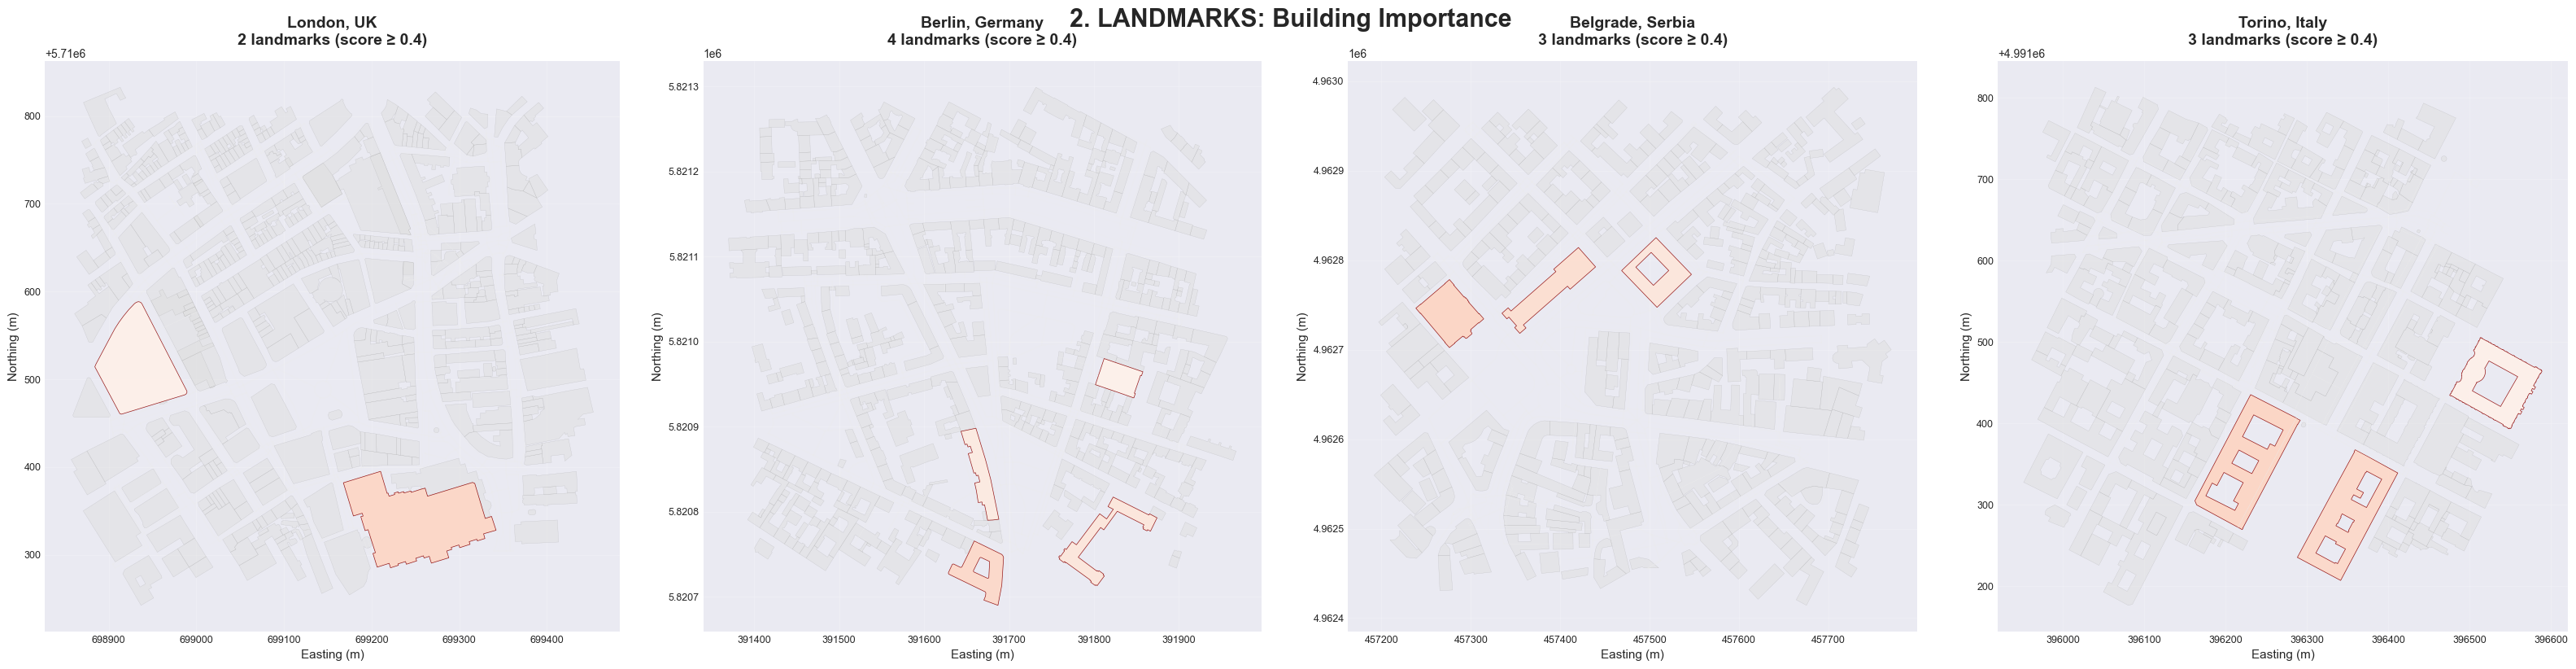

✓ Saved: 02_landmarks (PNG + SVG)


In [23]:
# 2. LANDMARKS - Color-coded by importance score
print("\n" + "="*60)
print("2/6: Creating Landmark visualizations...")
print("="*60)

fig, axes = plt.subplots(1, 4, figsize=(32, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    buildings = city_data[city_key]['buildings_scored']
    edges_gdf = city_data[city_key]['edges']
    
    # Plot edges (background)
    edges_gdf.plot(ax=ax, color='#EEEEEE', linewidth=0.5, alpha=0.3)
    
    # Identify landmarks: use ONLY hard threshold (no max limit)
    landmarks = buildings[buildings['global_score'] >= LANDMARK_THRESHOLD].copy()
    regular = buildings[buildings['global_score'] < LANDMARK_THRESHOLD].copy()
    
    # Plot regular buildings in light gray
    if len(regular) > 0:
        regular.plot(ax=ax, color='#E0E0E0', edgecolor='#999999', linewidth=0.2, alpha=0.5)
    
    # Plot landmarks in red (graduated by score)
    if len(landmarks) > 0:
        landmarks.plot(
            ax=ax,
            column='global_score',
            cmap='Reds',
            edgecolor='darkred',
            linewidth=0.5,
            alpha=0.9,
            vmin=LANDMARK_THRESHOLD,
            vmax=1.0
        )
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"{len(landmarks)} landmarks (score ≥ {LANDMARK_THRESHOLD:.1f})",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('2. LANDMARKS: Building Importance', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '02_landmarks.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '02_landmarks.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 02_landmarks (PNG + SVG)")

## 8. Building Footprint Library
Extract diverse individual building footprints (not blocks!)

In [24]:
def extract_building_footprint_library(buildings_gdf, city_key, target_count=35):
    """Extract diverse building footprints"""
    print(f"  Extracting {target_count} footprints...")
    
    if len(buildings_gdf) == 0:
        return []
    
    # Sort by area for diversity
    buildings = buildings_gdf.copy().sort_values('area')
    
    if len(buildings) <= target_count:
        selected = buildings
    else:
        indices = np.linspace(0, len(buildings)-1, target_count, dtype=int)
        selected = buildings.iloc[indices]
    
    library = []
    for idx, (_, row) in enumerate(selected.iterrows()):
        geom = row.geometry
        centroid = geom.centroid
        
        # Translate to origin
        translated = translate(geom, xoff=-centroid.x, yoff=-centroid.y)
        
        library.append({
            'footprint_id': f"{city_key}_building_{idx:03d}",
            'city': city_key,
            'area': float(row['area']),
            'aspect_ratio': float(row.get('aspect_ratio', 1.0)),
            'structural_score': float(row.get('structural_score', 0.5)),
            'geometry': {
                'type': 'Polygon',
                'coordinates': [list(translated.exterior.coords)]
            }
        })
    
    print(f"  ✓ Extracted {len(library)} footprints")
    return library

# Extract for all cities
all_footprints = []
for city_key in city_data.keys():
    print(f"\n{city_data[city_key]['name']}:")
    footprints = extract_building_footprint_library(
        city_data[city_key]['buildings_scored'],
        city_key,
        FOOTPRINTS_PER_CITY
    )
    all_footprints.extend(footprints)
    city_data[city_key]['footprint_library'] = footprints

print(f"\n{'='*60}")
print(f"✓ Total footprint library: {len(all_footprints)} buildings")
print(f"{'='*60}")

# Save
if len(all_footprints) > 0:
    with open(METRICS_DIR / 'building_footprint_library.json', 'w') as f:
        json.dump(all_footprints, f, indent=2)
    print(f"✓ Saved to building_footprint_library.json")


London, UK:
  Extracting 35 footprints...
  ✓ Extracted 35 footprints

Berlin, Germany:
  Extracting 35 footprints...
  ✓ Extracted 35 footprints

Belgrade, Serbia:
  Extracting 35 footprints...
  ✓ Extracted 35 footprints

Torino, Italy:
  Extracting 35 footprints...
  ✓ Extracted 35 footprints

✓ Total footprint library: 140 buildings
✓ Saved to building_footprint_library.json


## 9. Metrics Aggregation

In [25]:
def compute_distribution(values, bins=20):
    if len(values) == 0:
        return {'bins': [], 'counts': [], 'mean': 0, 'median': 0, 'std': 0, 'min': 0, 'max': 0}
    hist, bin_edges = np.histogram(values, bins=bins)
    return {
        'bins': bin_edges.tolist(),
        'counts': hist.tolist(),
        'mean': float(np.mean(values)),
        'median': float(np.median(values)),
        'std': float(np.std(values)),
        'min': float(np.min(values)),
        'max': float(np.max(values))
    }

urban_metrics = {}
for city_key in city_data.keys():
    print(f"\nAggregating: {city_data[city_key]['name']}...")
    
    nodes = city_data[city_key]['nodes']
    edges = city_data[city_key]['edges']
    parcels = city_data[city_key]['parcels_processed']
    buildings = city_data[city_key]['buildings_scored']
    partitions = city_data[city_key]['partitions']
    
    urban_metrics[city_key] = {
        'name': city_data[city_key]['name'],
        'nodes': {
            'total_count': len(nodes),
            'avg_degree': float(nodes['degree'].mean()),
            'degree_distribution': nodes['degree'].value_counts().to_dict()
        },
        'edges': {
            'total_count': len(edges),
            'total_length_m': float(edges['length'].sum()),
            'density_m_per_km2': float(edges['length'].sum() / 0.25),
            'segment_length_distribution': compute_distribution(edges['length'].values)
        },
        'parcels': {
            'total_count': len(parcels),
            'area_distribution': compute_distribution(parcels['area'].values) if len(parcels) > 0 else {}
        },
        'buildings': {
            'total_count': len(buildings),
            'area_distribution': compute_distribution(buildings['area'].values),
            'aspect_ratio_distribution': compute_distribution(buildings['aspect_ratio'].values)
        },
        'districts': {
            'count_distance': len(set(partitions['distance'].values())),
            'count_angular': len(set(partitions['angular'].values())),
            'count_topological': len(set(partitions['topological'].values()))
        }
    }

with open(METRICS_DIR / 'urban_metrics.json', 'w') as f:
    json.dump({'urban_metrics': urban_metrics}, f, indent=2)

print(f"\n{'='*60}")
print(f"✓ Saved to urban_metrics.json")
print(f"{'='*60}")


Aggregating: London, UK...

Aggregating: Berlin, Germany...

Aggregating: Belgrade, Serbia...

Aggregating: Torino, Italy...

✓ Saved to urban_metrics.json


## 10. Metrics Summary Table

In [26]:
# Create summary table
print("\n" + "="*80)
print("📊 METRICS SUMMARY TABLE")
print("="*80)

table_data = []
metrics = [
    ('Nodes', lambda m: m['nodes']['total_count']),
    ('Edges', lambda m: m['edges']['total_count']),
    ('Street Length (m)', lambda m: m['edges']['total_length_m']),
    ('Street Density (m/km²)', lambda m: m['edges']['density_m_per_km2']),
    ('Avg Segment (m)', lambda m: m['edges']['segment_length_distribution']['mean']),
    ('Parcels', lambda m: m['parcels']['total_count']),
    ('Buildings', lambda m: m['buildings']['total_count']),
    ('Avg Building Area (m²)', lambda m: m['buildings']['area_distribution']['mean']),
    ('Districts (distance)', lambda m: m['districts']['count_distance'])
]

for metric_name, func in metrics:
    row = {'Metric': metric_name}
    for city_key in city_data.keys():
        try:
            row[city_data[city_key]['name']] = f"{func(urban_metrics[city_key]):.1f}"
        except:
            row[city_data[city_key]['name']] = 'N/A'
    table_data.append(row)

df = pd.DataFrame(table_data).set_index('Metric')
print("\n" + df.to_string())

df.to_csv(METRICS_DIR / 'metrics_summary.csv')
print(f"\n✓ Saved to metrics_summary.csv")
print("="*80)


📊 METRICS SUMMARY TABLE

                       London, UK Berlin, Germany Belgrade, Serbia Torino, Italy
Metric                                                                          
Nodes                       525.0           403.0            286.0         290.0
Edges                      1431.0          1105.0            802.0         787.0
Street Length (m)         28315.5         22541.3          21251.1       18675.8
Street Density (m/km²)   113262.1         90165.3          85004.4       74703.2
Avg Segment (m)              19.8            20.4             26.5          23.7
Parcels                      14.0            11.0              1.0           3.0
Buildings                   507.0           433.0            356.0         275.0
Avg Building Area (m²)      341.0           256.7            354.4         599.6
Districts (distance)         34.0            22.0             29.0          25.0

✓ Saved to metrics_summary.csv


In [27]:
# RADAR METRICS COMPUTATION - Must come BEFORE visualizations
print("\n" + "="*60)
print("Computing radar chart metrics...")
print("="*60)

# Compute meaningful metrics for each city
radar_data = {}

for city_key in city_data.keys():
    nodes = city_data[city_key]['nodes']
    edges = city_data[city_key]['edges']
    buildings = city_data[city_key]['buildings_scored']
    G = city_data[city_key]['graph']
    partition = city_data[city_key]['partitions']['distance']
    
    # 1. Node Integration: Mean betweenness centrality
    node_integration = float(nodes['bc_distance'].mean())
    
    # 2. Edge Connectivity: Average closeness centrality
    edge_connectivity = float(nodes['closeness'].mean())
    
    # 3. Landmark Prominence: Mean score of landmarks (using hard threshold 0.4)
    landmarks = buildings[buildings['global_score'] >= LANDMARK_THRESHOLD]
    if len(landmarks) > 0:
        landmark_prominence = float(landmarks['global_score'].mean())
    else:
        landmark_prominence = 0.0
    
    # 4. District Coherence: Inverse of district density (fewer districts = more coherent)
    n_districts = len(set(partition.values()))
    n_nodes = len(nodes)
    district_coherence = 1 - (n_districts / n_nodes) if n_nodes > 0 else 0.5
    
    # 5. Path Efficiency: Ratio of high-betweenness edges (concentrated flow = higher efficiency)
    # More concentrated movement (fewer but stronger paths) = higher efficiency
    if len(edges) > 0:
        # Calculate what percentage of edges carry significant flow
        edge_bc_sorted = edges['edge_bc'].sort_values(ascending=False)
        top_20pct_idx = max(1, int(len(edge_bc_sorted) * 0.2))
        top_20pct_flow = edge_bc_sorted.iloc[:top_20pct_idx].sum()
        # Higher value = more concentrated/efficient path structure
        path_efficiency = float(top_20pct_flow)
    else:
        path_efficiency = 0.0
    
    radar_data[city_key] = {
        'Node Integration': node_integration,
        'Edge Connectivity': edge_connectivity,
        'Landmark Prominence': landmark_prominence,
        'District Coherence': district_coherence,
        'Path Efficiency': path_efficiency
    }

# Normalize all metrics to 0-1 scale for fair comparison
metrics_names = ['Node Integration', 'Edge Connectivity', 'Landmark Prominence', 
                 'District Coherence', 'Path Efficiency']

# Get max/min values for normalization
max_values = {m: max(radar_data[c][m] for c in city_data.keys()) for m in metrics_names}
min_values = {m: min(radar_data[c][m] for c in city_data.keys()) for m in metrics_names}

# Normalize to 0-1 range
for city_key in radar_data.keys():
    for metric in metrics_names:
        val_range = max_values[metric] - min_values[metric]
        if val_range > 0:
            radar_data[city_key][metric] = (radar_data[city_key][metric] - min_values[metric]) / val_range
        else:
            radar_data[city_key][metric] = 0.5

print("Radar metrics computed:")
for city_key in city_data.keys():
    print(f"  {city_data[city_key]['name']}:")
    for metric in metrics_names:
        print(f"    {metric}: {radar_data[city_key][metric]:.3f}")

print("✓ Metrics ready for visualization")


Computing radar chart metrics...
Radar metrics computed:
  London, UK:
    Node Integration: 0.000
    Edge Connectivity: 0.000
    Landmark Prominence: 0.263
    District Coherence: 0.783
    Path Efficiency: 0.500
  Berlin, Germany:
    Node Integration: 0.149
    Edge Connectivity: 0.367
    Landmark Prominence: 0.000
    District Coherence: 1.000
    Path Efficiency: 0.500
  Belgrade, Serbia:
    Node Integration: 1.000
    Edge Connectivity: 0.488
    Landmark Prominence: 1.000
    District Coherence: 0.000
    Path Efficiency: 0.500
  Torino, Italy:
    Node Integration: 0.800
    Edge Connectivity: 1.000
    Landmark Prominence: 0.688
    District Coherence: 0.325
    Path Efficiency: 0.500
✓ Metrics ready for visualization


## 11. Space Syntax Visualizations

Create comprehensive visualizations for the 5 Kevin Lynch elements:
1. Nodes (centrality-based sizing)
2. Landmarks (color-coded by importance)
3. Districts (community detection)
4. Paths (edge betweenness)
5. Edges (connectivity)

Then create overlay and analysis visualizations.


Creating building footprint visualization (6 per city)...


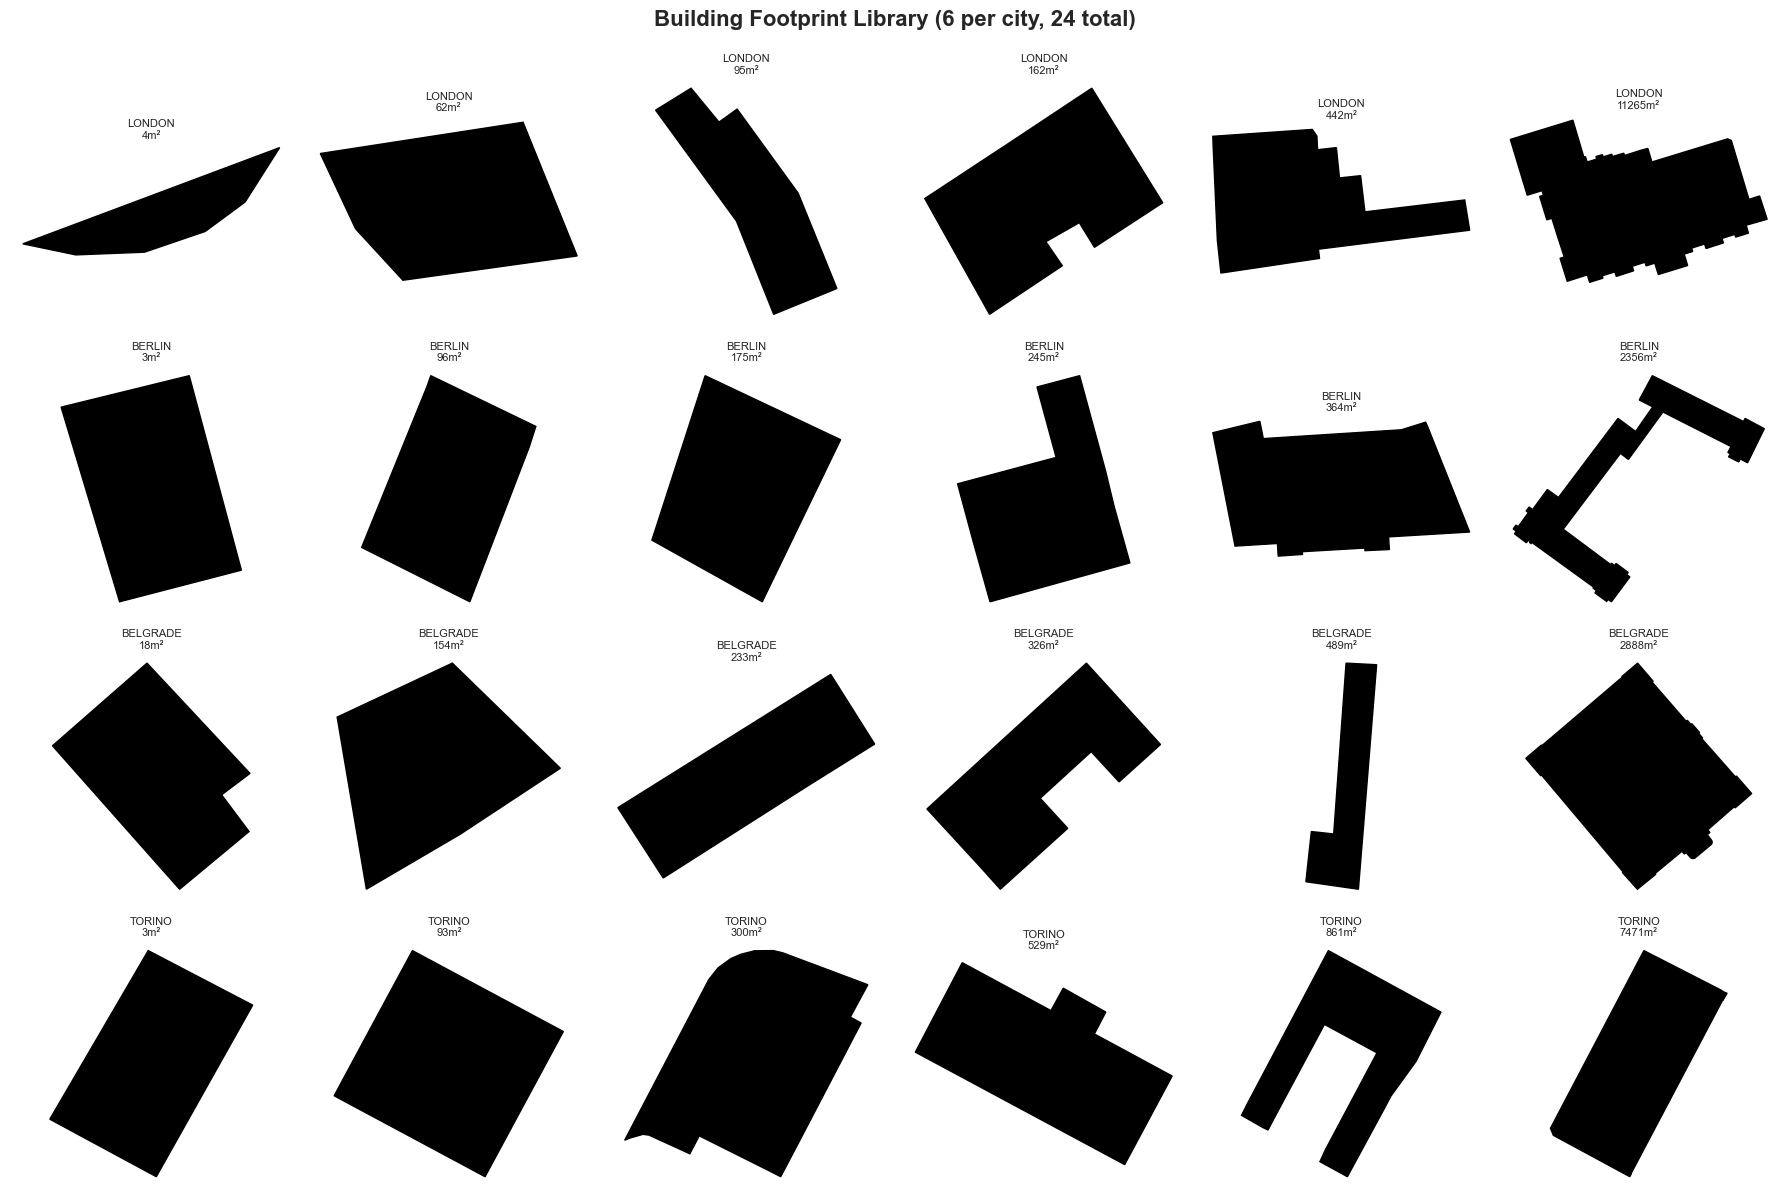

✓ Saved: 07_footprints_6per (PNG + SVG)
  Grid: 4 cities × 6 footprints = 24 total


In [28]:
# BUILDING FOOTPRINTS - 6 per city, all black
print("\n" + "="*60)
print("Creating building footprint visualization (6 per city)...")
print("="*60)

if len(all_footprints) > 0:
    # Select 6 footprints per city (24 total for 4 cities)
    selected_footprints = []
    for city_key in city_data.keys():
        city_footprints = city_data[city_key]['footprint_library']
        if len(city_footprints) >= 6:
            # Select evenly distributed footprints
            indices = [0, len(city_footprints)//5, 2*len(city_footprints)//5, 
                      3*len(city_footprints)//5, 4*len(city_footprints)//5, len(city_footprints)-1]
            selected = [city_footprints[i] for i in indices]
        else:
            selected = city_footprints[:6]
        selected_footprints.extend(selected)
    
    # Create 4x6 grid
    fig, axes = plt.subplots(4, 6, figsize=(18, 12), facecolor='white')
    
    for idx, fp in enumerate(selected_footprints):
        row = idx // 6
        col = idx % 6
        ax = axes[row, col]
        
        poly = Polygon(fp['geometry']['coordinates'][0])
        x, y = poly.exterior.xy
        
        # ALL BLACK
        ax.fill(x, y, color='black', alpha=1.0, edgecolor='black', linewidth=1)
        ax.set_title(
            f"{fp['city'].upper()}\n{fp['area']:.0f}m²",
            fontsize=8, pad=3
        )
        ax.set_aspect('equal')
        ax.axis('off')
    
    plt.suptitle(
        f'Building Footprint Library (6 per city, {len(selected_footprints)} total)',
        fontsize=16, fontweight='bold', y=0.995
    )
    plt.tight_layout()
    plt.savefig(VIZ_PNG_DIR / '07_footprints_6per.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(VIZ_SVG_DIR / '07_footprints_6per.svg', bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✓ Saved: 07_footprints_6per (PNG + SVG)")
    print(f"  Grid: 4 cities × 6 footprints = {len(selected_footprints)} total")
else:
    print("⚠ No footprints to visualize")


Creating individual radar charts...


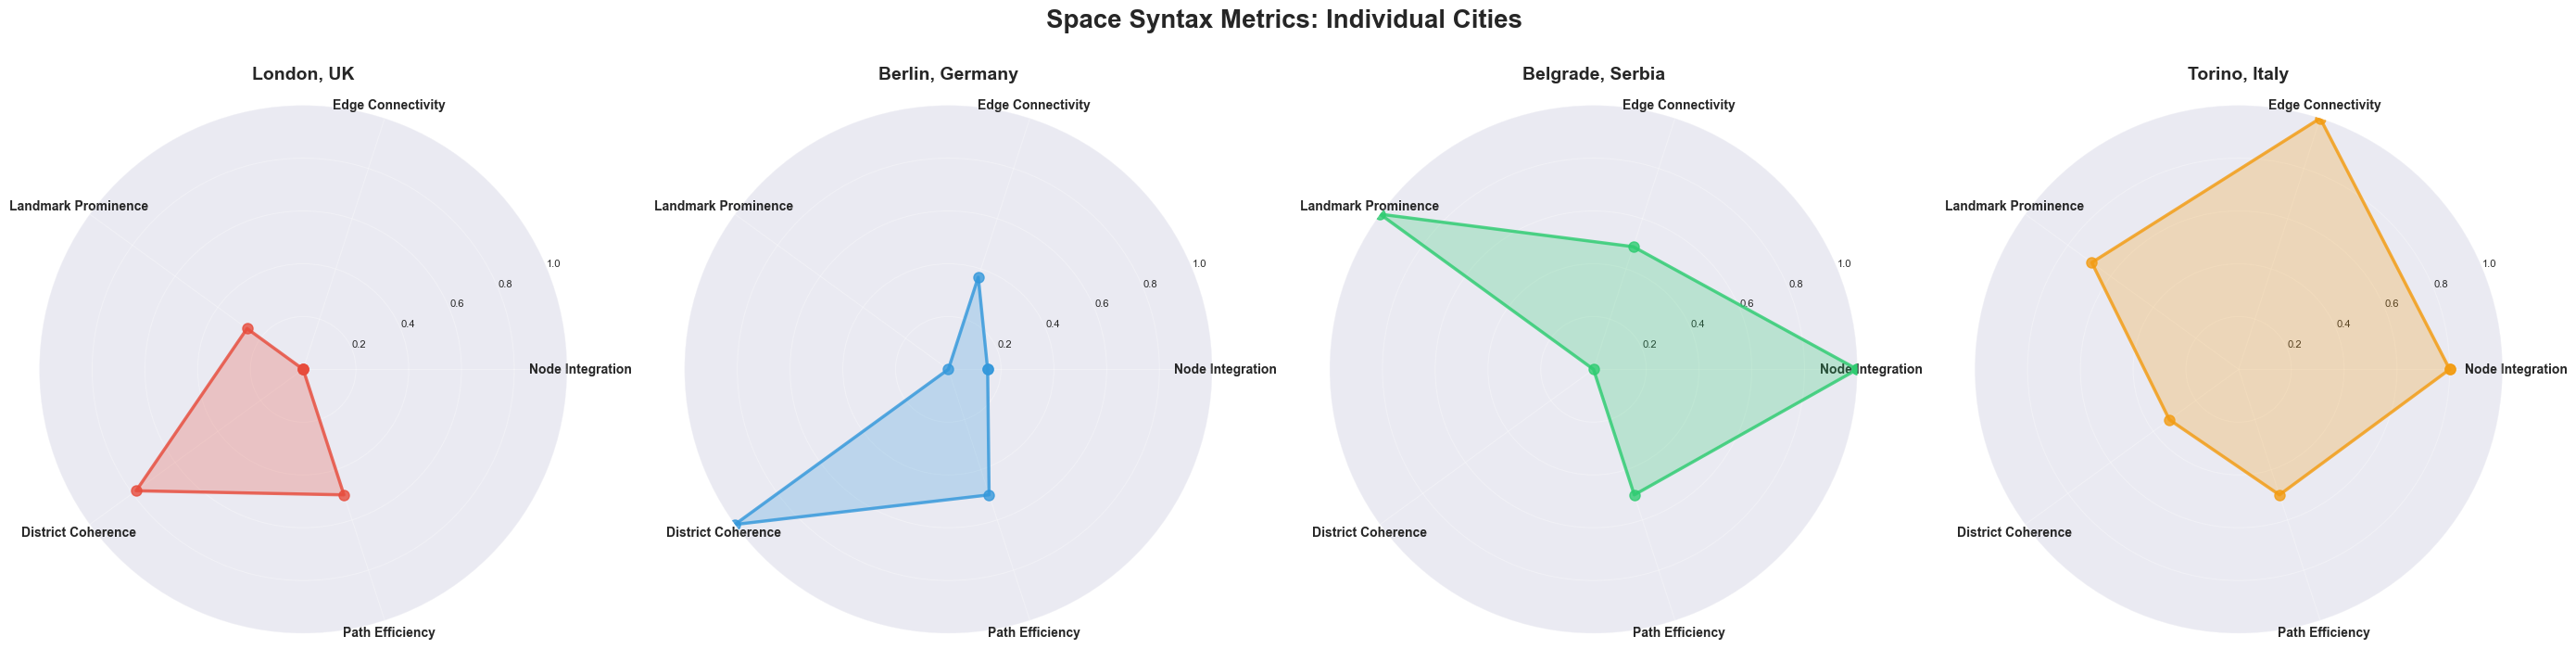

✓ Saved: 08_radar_individual (PNG + SVG)


In [29]:
# 9. RADAR CHARTS - Individual city visualizations
print("\nCreating individual radar charts...")

fig, axes = plt.subplots(1, 4, figsize=(28, 7), subplot_kw=dict(projection='polar'), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    # Get values
    values = [radar_data[city_key][m] for m in metrics_names]
    values += values[:1]  # Close the polygon
    
    # Set up angles
    angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2.5, color=city_data[city_key]['color'], 
            markersize=8, alpha=0.8)
    ax.fill(angles, values, alpha=0.25, color=city_data[city_key]['color'])
    
    # Formatting
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_names, fontsize=10, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{city_data[city_key]['name']}", fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Space Syntax Metrics: Individual Cities', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '08_radar_individual.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '08_radar_individual.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 08_radar_individual (PNG + SVG)")


Creating overlaid radar chart...


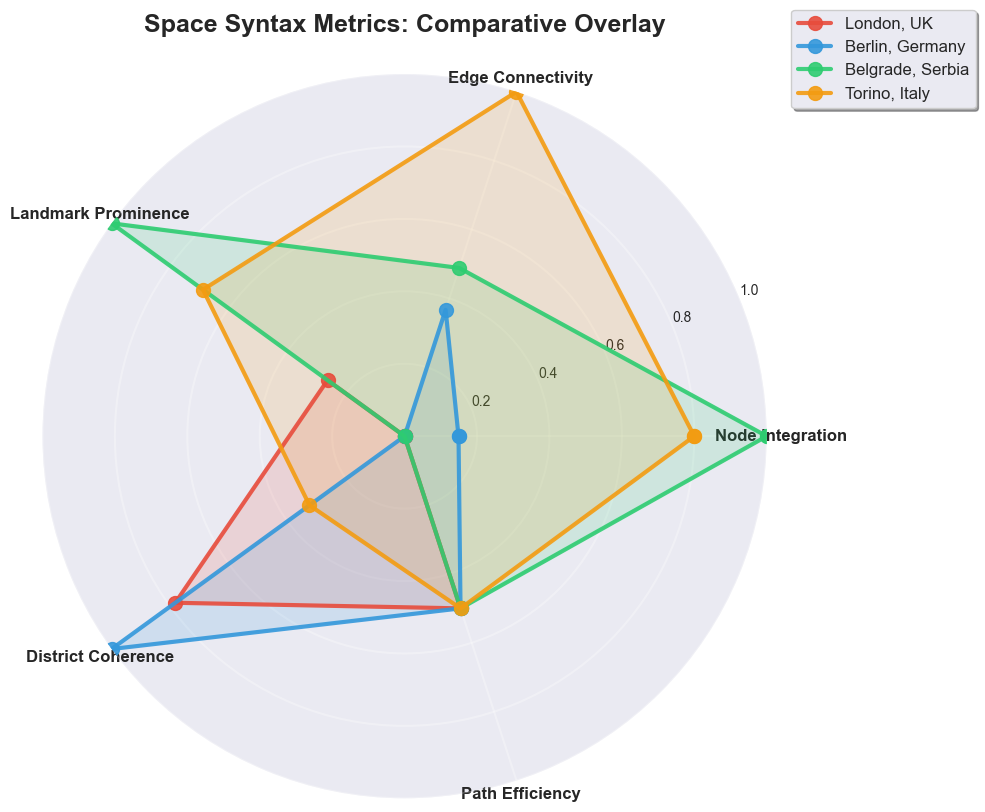

✓ Saved: 09_radar_overlay (PNG + SVG)


In [30]:
# 10. RADAR CHART - Overlay comparison
print("\nCreating overlaid radar chart...")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'), facecolor='white')

# Set up angles
angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
angles += angles[:1]

# Plot all cities on same chart
for city_key in city_data.keys():
    values = [radar_data[city_key][m] for m in metrics_names]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=3, color=city_data[city_key]['color'],
            label=city_data[city_key]['name'], markersize=10, alpha=0.9)
    ax.fill(angles, values, alpha=0.15, color=city_data[city_key]['color'])

# Formatting
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_names, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.3, linewidth=1.5)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12, frameon=True, shadow=True)

plt.title('Space Syntax Metrics: Comparative Overlay', fontsize=18, fontweight='bold', pad=30)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '09_radar_overlay.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '09_radar_overlay.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 09_radar_overlay (PNG + SVG)")


6/6: Creating OVERLAY visualization (all elements)...


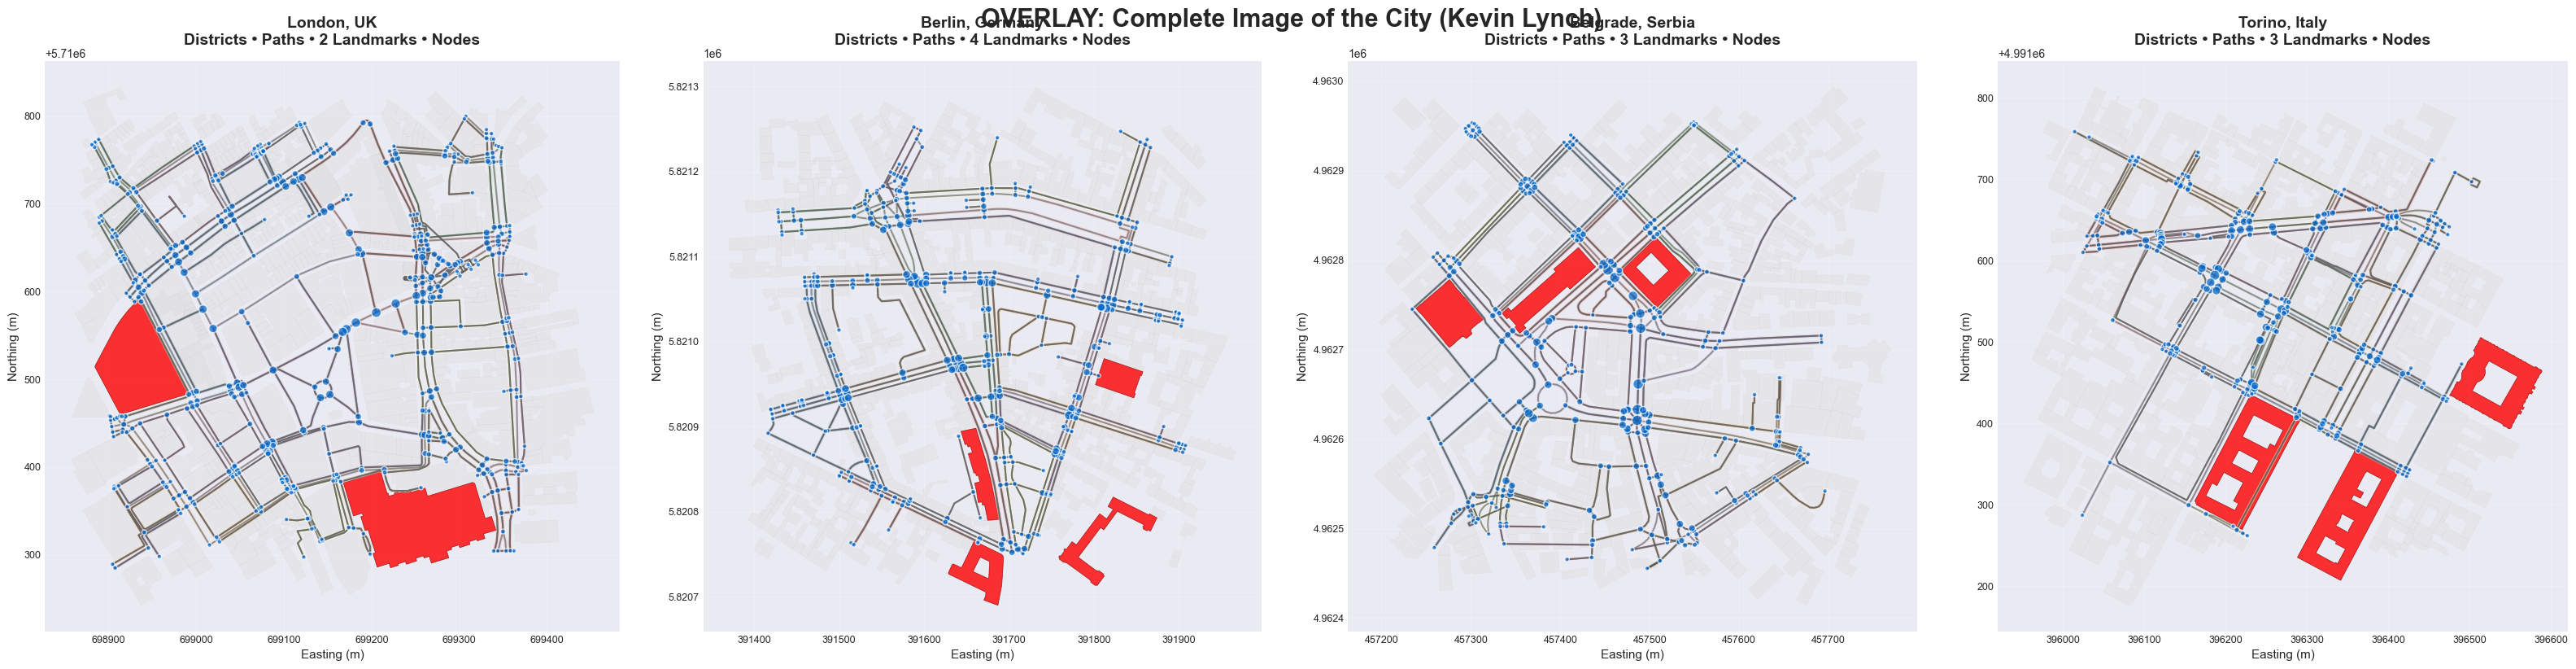

✓ Saved: 06_overlay_all_elements (PNG + SVG)

✓ All 6 space syntax visualizations complete!


In [32]:
# 6. OVERLAY - All 5 Kevin Lynch elements combined
print("\n" + "="*60)
print("6/6: Creating OVERLAY visualization (all elements)...")
print("="*60)

fig, axes = plt.subplots(1, 4, figsize=(32, 8), facecolor='white')

for idx, city_key in enumerate(city_data.keys()):
    ax = axes[idx]
    
    nodes_gdf = city_data[city_key]['nodes']
    edges_gdf = city_data[city_key]['edges']
    buildings = city_data[city_key]['buildings_scored']
    partition = city_data[city_key]['partitions']['distance']
    
    # Layer 1: Districts (as background color on edges)
    edge_districts = []
    for u, v, k in edges_gdf.index:
        d1 = partition.get(u, 0)
        d2 = partition.get(v, 0)
        edge_districts.append(max(d1, d2))
    edges_with_district = edges_gdf.copy()
    edges_with_district['district'] = edge_districts
    n_districts = len(set(partition.values()))
    cmap_districts = plt.cm.get_cmap('Pastel1', n_districts)
    edges_with_district.plot(ax=ax, column='district', cmap=cmap_districts, linewidth=3, alpha=0.3)
    
    # Layer 2: Paths (edge betweenness as line width)
    max_bc = edges_gdf['edge_bc'].max()
    if max_bc > 0:
        linewidths = (edges_gdf['edge_bc'] / max_bc) * 4 + 0.5
    else:
        linewidths = 1.5
    edges_gdf.plot(ax=ax, color='#555555', linewidth=linewidths, alpha=0.6)
    
    # Layer 3: Landmarks (use hard threshold only)
    landmarks = buildings[buildings['global_score'] >= LANDMARK_THRESHOLD].copy()
    regular = buildings[buildings['global_score'] < LANDMARK_THRESHOLD].copy()
    
    if len(regular) > 0:
        regular.plot(ax=ax, color='#DDDDDD', edgecolor='#AAAAAA', linewidth=0.1, alpha=0.4)
    if len(landmarks) > 0:
        landmarks.plot(ax=ax, color='#FF0000', edgecolor='darkred', linewidth=0.5, alpha=0.8)
    
    # Layer 4: Nodes (sized by centrality)
    node_sizes = (nodes_gdf['bc_distance'] * 300) + 15
    nodes_gdf.plot(ax=ax, markersize=node_sizes, color='#0066CC', 
                   alpha=0.7, edgecolor='white', linewidth=1, zorder=5)
    
    ax.set_title(
        f"{city_data[city_key]['name']}\n"
        f"Districts • Paths • {len(landmarks)} Landmarks • Nodes",
        fontsize=14, fontweight='bold', pad=15
    )
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.tick_params(labelsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('OVERLAY: Complete Image of the City (Kevin Lynch)', fontsize=22, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIZ_PNG_DIR / '06_overlay_all_elements.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(VIZ_SVG_DIR / '06_overlay_all_elements.svg', bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: 06_overlay_all_elements (PNG + SVG)")
print("\n" + "="*60)
print("✓ All 6 space syntax visualizations complete!")
#print("="*60)")

## 12. Final Summary

In [ ]:
print("\n" + "="*80)
print("✓ STEP 1 COMPLETE: COMPREHENSIVE URBAN ANALYSIS")
print("="*80)

print("\n📁 OUTPUTS:")
print(f"  GeoJSON: {len(list(GEOJSON_DIR.glob('*.geojson')))} files")
print(f"  PNG: {len(list(VIZ_PNG_DIR.glob('*.png')))} files")
print(f"  SVG: {len(list(VIZ_SVG_DIR.glob('*.svg')))} files")
print(f"  Metrics: {len(list(METRICS_DIR.glob('*')))} files")

print("\n📊 VISUALIZATIONS CREATED:")
print("  1. Base Maps (00)")
print("  2. Node Centrality (01)")
print("  3. Landmarks (02)")
print("  4. Districts (03)")
print("  5. Paths/Edge Betweenness (04)")
print("  6. Edges/Angular (05)")
print("  7. Complete Overlay (06)")
print("  8. ALL Building Footprints - 105 total (07)")
print("  9. Radar Charts - Individual (08)")
print("  10. Radar Chart - Overlay (09)")
print("  11. Improved Histograms (10)")

print("\n🏗️ SPACE SYNTAX ELEMENTS:")
print("  ✓ Nodes: Sized by betweenness centrality")
print("  ✓ Landmarks: Color-coded by importance (top 10%)")
print("  ✓ Districts: Community detection with Louvain")
print("  ✓ Paths: Edge betweenness (movement corridors)")
print("  ✓ Edges: Angular integration")
print("  ✓ Overlay: All 5 elements combined")

print("\n📐 METRICS:")
for city_key in city_data.keys():
    m = urban_metrics[city_key]
    print(f"  {m['name']}:")
    print(f"    - {m['buildings']['total_count']} buildings")
    print(f"    - {m['parcels']['total_count']} parcels")
    print(f"    - {len(city_data[city_key]['footprint_library'])} in footprint library")
    print(f"    - {m['districts']['count_distance']} districts")
    print(f"    - Node Integration: {radar_data[city_key]['Node Integration']:.3f}")

print(f"\n  TOTAL FOOTPRINT LIBRARY: {len(all_footprints)} buildings")

print("\n✅ DELIVERABLES:")
print("  ✓ All visualizations: PNG (300 DPI) + SVG (vector)")
print("  ✓ Building footprints: Individual shapes (NOT blocks)")
print("  ✓ Building parcels: Landuse boundaries from OSM")
print("  ✓ Space syntax: 5 Kevin Lynch elements visualized")
print("  ✓ Radar charts: Meaningful metrics for comparative analysis")
print("  ✓ Improved histograms: Bar-based with outlier removal")
print("="*80)

In [ ]:
print("\n" + "="*80)
print("✓ STEP 1 COMPLETE: URBAN ANALYSIS")
print("="*80)

print("\n📁 OUTPUTS:")
print(f"  GeoJSON: {len(list(GEOJSON_DIR.glob('*.geojson')))} files")
print(f"  PNG: {len(list(VIZ_PNG_DIR.glob('*.png')))} files")
print(f"  SVG: {len(list(VIZ_SVG_DIR.glob('*.svg')))} files")
print(f"  Metrics: {len(list(METRICS_DIR.glob('*')))} files")

print("\n📊 RESULTS:")
for city_key in city_data.keys():
    m = urban_metrics[city_key]
    print(f"  {m['name']}: {m['buildings']['total_count']} buildings, "
          f"{m['parcels']['total_count']} parcels, "
          f"{len(city_data[city_key]['footprint_library'])} in library")

print(f"\n  TOTAL FOOTPRINT LIBRARY: {len(all_footprints)} buildings")

print("\n✓ All visualizations: PNG + SVG")
print("✓ Building footprints: Individual shapes (not blocks)")
print("✓ Parcels: Landuse boundaries from OSM")
print("="*80)